In [35]:
from ott.geometry import pointcloud
from ott.solvers.linear import sinkhorn
from ott.problems.linear import linear_problem

from sentence_transformers import SentenceTransformer, util

import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple
from tqdm import tqdm

In [36]:
embedding_model="all-mpnet-base-v2"
# embedding_model="all-MiniLM-L6-v2"
model = SentenceTransformer(embedding_model)

def embed(src: list, trg: list) -> Tuple[np.ndarray, np.ndarray]:
    src_embeddings = model.encode(src)
    trg_embeddings = model.encode(trg)

    return src_embeddings, trg_embeddings

In [37]:
def uot(src_embeddings: np.ndarray, trg_embeddings: np.ndarray, penalty_src=0.999, penalty_trg=0.9):
    n, m = len(src_embeddings), len(trg_embeddings)
    geom = pointcloud.PointCloud(src_embeddings, trg_embeddings)
    problem = linear_problem.LinearProblem(geom, 
                                           a = np.ones(shape=(n)),
                                           b = np.ones(shape=(m)) / m * n,
                                           tau_a = penalty_src, tau_b = penalty_trg)
    output = sinkhorn.Sinkhorn()(problem)

    return output.matrix

def uot_matching(src: list, trg: list, penalty_src=0.999, penalty_trg=0.9, threshold=0.0, plot=False):
    src_embeddings, trg_embeddings = embed(src, trg)

    candidate_matching = uot(src_embeddings, trg_embeddings, penalty_src, penalty_trg)
    src_confidences = np.sum(candidate_matching, axis=1) * len(src_embeddings)

    candidate_map = np.argmax(candidate_matching, axis=1)
    matching_confidences = np.max(candidate_matching, axis=1) / np.sum(candidate_matching, axis=1)

    if plot:
        plt.imshow(candidate_matching)
        plt.yticks(ticks=range(len(src)), labels=src)
        plt.xticks(ticks=range(len(trg)), labels=trg, rotation=60, ha='right')
        plt.title('')
        plt.show()

    if threshold:
        return [trg[x]
                if matching_confidences[i]*src_confidences[i] >= threshold
                else ""
                for i, x in enumerate(candidate_map)]
    else:
        return [(trg[x], matching_confidences[i]*src_confidences[i]) for i, x in enumerate(candidate_map)]
    
def cossim_matching(src: list, trg: list, threshold=0.0):
    src_embeddings, trg_embeddings = embed(src, trg)
    cos_scores = util.cos_sim(src_embeddings, trg_embeddings)

    candidate_map = np.argmax(cos_scores, axis=1)

    if threshold:
        return [trg[j] if cos_scores[i,j] >= threshold else "" for i, j in enumerate(candidate_map)]
    else:
        return [(trg[j], float(cos_scores[i,j])) for i, j in enumerate(candidate_map) ]


In [38]:
def eval_gt(matching, ground_truth):
    acc, fp, fn = 0, 0, 0
    for i in range(len(matching)):
        if type(ground_truth[i]) == list:
            if matching[i] in ground_truth[i]:
                acc += 1
            elif matching[i] == "":
                fn += 1

        elif matching[i] == ground_truth[i]:
            acc += 1
        elif matching[i] == "":
            fn += 1
        elif ground_truth[i] == "":
            fp += 1

    return {'acc': acc,
            'fp': fp,
            'fn': fn}

In [39]:
import json

with open('var_match_dataset.json', 'r') as problem_file:
    problem_dict = json.load(problem_file)

with open('var_match_gt.json', 'r') as gt_file:
    gt_dict = json.load(gt_file)

In [40]:
threshold_list = np.arange(0,1.0,0.1)
plot_dict = {}

In [41]:
results = {t: {} for t in threshold_list}
for instance, problem in tqdm(problem_dict.items()):
    ground_truth = gt_dict[instance]['ground truth']
    matching = cossim_matching(problem['variables'], problem['sensors'], threshold=None)

    thresh_matching = [match for match, _ in matching]
    for threshold in threshold_list:
        for i, (match, score) in enumerate(matching):
            if score < threshold:
                thresh_matching[i] = ""
        results[threshold][instance] = eval_gt(thresh_matching, ground_truth)

plot_dict[f'Cosine Similarity'] = {'acc': [np.mean([x['acc'] for x in results[t].values()]) for t in threshold_list],
                                   'fp': [np.mean([x['fp'] for x in results[t].values()]) for t in threshold_list],
                                   'fn': [np.mean([x['fn'] for x in results[t].values()]) for t in threshold_list]}

100%|██████████| 120/120 [00:05<00:00, 22.96it/s]


In [54]:
"(1.0, 0.9), (1.0, 0.85), (1.0, 0.8), same with 0.999"
penalties = (0.99, 0.8)

results = {t: {} for t in threshold_list}
for instance, problem in tqdm(problem_dict.items()):
    ground_truth = gt_dict[instance]['ground truth']
    matching = uot_matching(problem['variables'], problem['sensors'], penalty_src=penalties[0], penalty_trg=penalties[1], threshold=None)

    thresh_matching = [match for match, _ in matching]
    for threshold in threshold_list:
        for i, (match, score) in enumerate(matching):
            if score < threshold:
                thresh_matching[i] = ""
        results[threshold][instance] = eval_gt(thresh_matching, ground_truth)

plot_dict[f'OT ({penalties[0]}, {penalties[1]})'] = {'acc': [np.mean([x['acc'] for x in results[t].values()]) for t in threshold_list],
                                                     'fp': [np.mean([x['fp'] for x in results[t].values()]) for t in threshold_list],
                                                     'fn': [np.mean([x['fn'] for x in results[t].values()]) for t in threshold_list]}

100%|██████████| 120/120 [00:33<00:00,  3.59it/s]


Cosine Similarity: 70.52 @ 0.5
OT (1.0, 0.95): 72.25 @ 0.0
OT (1.0, 0.8): 71.29 @ 0.0
OT (0.999, 0.95): 72.25 @ 0.0
OT (0.99, 0.95): 72.25 @ 0.0
OT (0.99, 0.8): 71.48 @ 0.0


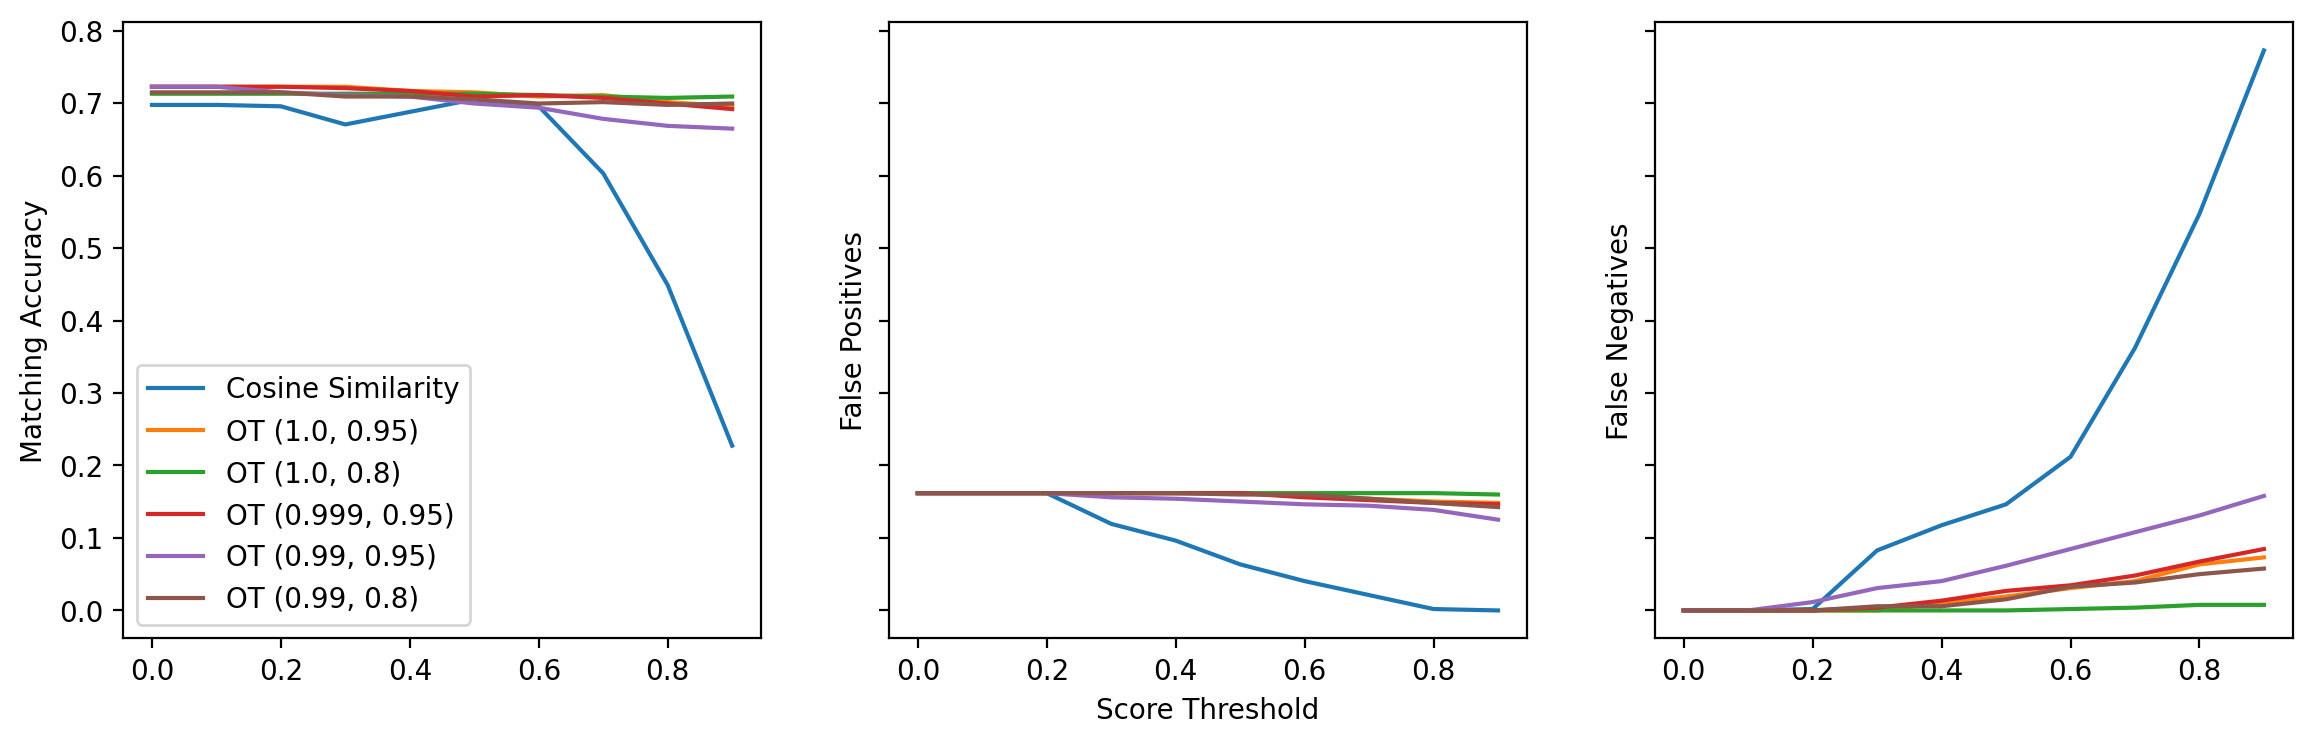

In [55]:
fig, axs = plt.subplots(1, 3, figsize=(14,4), sharey='all', dpi=200)

var_length = np.mean([len(x['variables']) for x in problem_dict.values()])

for key in plot_dict.keys():
    axs[0].plot([t for t in threshold_list], plot_dict[key]['acc'] / var_length, label=key)
    axs[1].plot([t for t in threshold_list], plot_dict[key]['fp'] / var_length, label=key)
    axs[2].plot([t for t in threshold_list], plot_dict[key]['fn'] / var_length, label=key)

# axs[0].set_ylim(0,1)
axs[0].set_ylabel('Matching Accuracy')
axs[1].set_ylabel('False Positives')
axs[2].set_ylabel('False Negatives')
axs[1].set_xlabel('Score Threshold')
axs[0].legend()

for key in plot_dict.keys():
    print(f"{key}: {100*np.max(plot_dict[key]['acc']) / var_length:.2f} @ {threshold_list[np.argmax(plot_dict[key]['acc'])]}")